In [1]:
ENV["LINES"] = 200
ENV["COLUMNS"] = 200
using Distributions
using Roots
using StatsPlots
default(fmt=:png)

In [2]:
logoddsrat(p0, p1) = (log(p0) - log(1-p0)) - (log(p1) - log(1-p1))
logcprat(p0, p1) = -(log(1-p0) - log(1-p1))
loglikrat(k, n, p0, p1) = loglikelihood(Binomial(n, p0), k) - loglikelihood(Binomial(n, p1), k)
lim_k_C(C, n, p0, p1) = (log(C) + n*logcprat(p0, p1)) / logoddsrat(p0, p1)

function alpha_k_C(k_C, n, p0, p1)
    bin0 = Binomial(n, p0)
    p0 < p1 && return ccdf(bin0, floor(Int, k_C))
    p0 > p1 && return cdf(bin0, ceil(Int, k_C)-1)
    NaN
end

alpha_C(C, n, p0, p1) = alpha_k_C(lim_k_C(C, n, p0, p1), n, p0, p1)

r(x) = round(x; sigdigits=4)

function sim_likrat_test_C(C, n, p0, p1; p=p0, niters=10^7)
    logC = log(C)
    bin = Binomial(n, p)
    c = zeros(Int, Threads.nthreads())
    Threads.@threads for i in 1:niters
        tid = Threads.threadid()
        k = rand(bin)
        @inbounds c[tid] += loglikrat(k, n, p0, p1) < logC
    end
    sum(c)/niters
end

function sim_likrat_test_k_C(k_C, n, p0, p1; p=p0, niters=10^7)
    bin = Binomial(n, p)
    c = zeros(Int, Threads.nthreads())
    Threads.@threads for i in 1:niters
        tid = Threads.threadid()
        k = rand(bin)
        c[tid] += p0 < p1 ? k > k_C : p0 > p1 ? k < k_C : NaN
    end
    sum(c)/niters
end

function sim_likrat_test_alpha(α, n, p0, p1; p=p0, niters=10^7)
    bin0 = Binomial(n, p0)
    bin = Binomial(n, p)
    c = zeros(Int, Threads.nthreads())
    Threads.@threads for i in 1:niters
        tid = Threads.threadid()
        k = rand(bin)
        c[tid] += p0 < p1 ? ccdf(bin0, k) < α : p0 > p1 ? cdf(bin0, k-1) < α : NaN
    end
    sum(c)/niters
end

sim_likrat_test_alpha (generic function with 1 method)

In [3]:
n = 100
p0 = 0.3
p1 = 0.5

alphas = [(k_C, alpha_k_C(k_C, n, p0, p1)) for k_C in 35:40]
@show collect(zip(first.(alphas), r.(last.(alphas))))

println()

C = 2.0
@show C
@show alpha_C(C, n, p0, p1) |> r
@show sim_likrat_test_C(C, n, p0, p1)

println()

@show k_C = lim_k_C(C, n, p0, p1) |> r
@show alpha_k_C(k_C, n, p0, p1) |> r
@show sim_likrat_test_k_C(k_C, n, p0, p1)

println()

@show α = 0.0339
@show sim_likrat_test_alpha(α, n, p0, p1)
@show sim_likrat_test_alpha(α, n, p0, p1; p=0.4)
@show sim_likrat_test_alpha(α, n, p0, p1; p=0.5)
;

collect(zip(first.(alphas), r.(last.(alphas)))) = [(35, 0.1161), (36, 0.07988), (37, 0.05305), (38, 0.03398), (39, 0.02099), (40, 0.0125)]

C = 2.0
alpha_C(C, n, p0, p1) |> r = 0.03398
sim_likrat_test_C(C, n, p0, p1) = 0.033885

k_C = lim_k_C(C, n, p0, p1) |> r = 38.89
alpha_k_C(k_C, n, p0, p1) |> r = 0.03398
sim_likrat_test_k_C(k_C, n, p0, p1) = 0.0339321

α = 0.0339 = 0.0339
sim_likrat_test_alpha(α, n, p0, p1) = 0.0340187
sim_likrat_test_alpha(α, n, p0, p1; p = 0.4) = 0.6180559
sim_likrat_test_alpha(α, n, p0, p1; p = 0.5) = 0.9895567


In [4]:
n = 100
p0 = 0.3
p1 = 0.1

alphas = [(k_C, alpha_k_C(k_C, n, p0, p1)) for k_C in 20:25]
@show collect(zip(first.(alphas), r.(last.(alphas))))

println()

C = 100.0
@show C
@show alpha_C(C, n, p0, p1) |> r
@show sim_likrat_test_C(C, n, p0, p1)

println()

@show k_C = lim_k_C(C, n, p0, p1) |> r
@show alpha_k_C(k_C, n, p0, p1) |> r
@show sim_likrat_test_k_C(k_C, n, p0, p1)

println()

@show α = 0.0478
@show sim_likrat_test_alpha(α, n, p0, p1)
@show sim_likrat_test_alpha(α, n, p0, p1; p=0.2)
@show sim_likrat_test_alpha(α, n, p0, p1; p=0.1)
;

collect(zip(first.(alphas), r.(last.(alphas)))) = [(20, 0.008887), (21, 0.01646), (22, 0.02883), (23, 0.04787), (24, 0.07553), (25, 0.1136)]

C = 100.0
alpha_C(C, n, p0, p1) |> r = 0.04787
sim_likrat_test_C(C, n, p0, p1) = 0.0478803

k_C = lim_k_C(C, n, p0, p1) |> r = 22.03
alpha_k_C(k_C, n, p0, p1) |> r = 0.04787
sim_likrat_test_k_C(k_C, n, p0, p1) = 0.0479124

α = 0.0478 = 0.0478
sim_likrat_test_alpha(α, n, p0, p1) = 0.0477964
sim_likrat_test_alpha(α, n, p0, p1; p = 0.2) = 0.7390428
sim_likrat_test_alpha(α, n, p0, p1; p = 0.1) = 0.9998854


In [5]:
n = 100
p0 = 0.3

alphas = [(C, p1, alpha_C(C, n, p0, p1)) for C in (0.1, 0.33, 1.0, 3.0, 10.0, 30.0, 100.0), p1 in (0.31, 0.4, 0.5, 0.6, 0.7)]

7×5 Matrix{Tuple{Float64, Float64, Float64}}:
 (0.1, 0.31, 7.0635e-25)  (0.1, 0.4, 0.0124984)   (0.1, 0.5, 0.00396779)   (0.1, 0.6, 0.000255833)   (0.1, 0.7, 3.56148e-6)
 (0.33, 0.31, 4.9323e-7)  (0.33, 0.4, 0.0530456)  (0.33, 0.5, 0.00717356)  (0.33, 0.6, 0.000537015)  (0.33, 0.7, 9.03469e-6)
 (1.0, 0.31, 0.450876)    (1.0, 0.4, 0.162858)    (1.0, 0.5, 0.0209886)    (1.0, 0.6, 0.00108575)    (1.0, 0.7, 2.20609e-5)
 (3.0, 0.31, 1.0)         (3.0, 0.4, 0.289281)    (3.0, 0.5, 0.033979)     (3.0, 0.6, 0.00211462)    (3.0, 0.7, 2.20609e-5)
 (10.0, 0.31, 1.0)        (10.0, 0.4, 0.53766)    (10.0, 0.5, 0.07988)     (10.0, 0.6, 0.00396779)   (10.0, 0.7, 5.18595e-5)
 (30.0, 0.31, 1.0)        (30.0, 0.4, 0.703634)   (30.0, 0.5, 0.116079)    (30.0, 0.6, 0.00717356)   (30.0, 0.7, 0.000117378)
 (100.0, 0.31, 1.0)       (100.0, 0.4, 0.88643)   (100.0, 0.5, 0.162858)   (100.0, 0.6, 0.0124984)   (100.0, 0.7, 0.000117378)

In [6]:
n = 100
p0 = 0.3

alphas = [(C, p1, alpha_C(C, n, p0, p1)) for C in (0.1, 0.33, 1.0, 3.0, 10.0, 30.0, 100.0), p1 in (0.25, 0.20, 0.15, 0.10, 0.05)]

7×5 Matrix{Tuple{Float64, Float64, Float64}}:
 (0.1, 0.25, 0.00452264)  (0.1, 0.2, 0.0164629)   (0.1, 0.15, 0.00888721)  (0.1, 0.1, 0.000968865)  (0.1, 0.05, 5.65497e-5)
 (0.33, 0.25, 0.0755308)  (0.33, 0.2, 0.0478657)  (0.33, 0.15, 0.0164629)  (0.33, 0.1, 0.00216293)  (0.33, 0.05, 0.000157341)
 (1.0, 0.25, 0.296366)    (1.0, 0.2, 0.11357)     (1.0, 0.15, 0.0288313)   (1.0, 0.1, 0.00452264)   (1.0, 0.05, 0.000157341)
 (3.0, 0.25, 0.633108)    (3.0, 0.2, 0.224399)    (3.0, 0.15, 0.0755308)   (3.0, 0.1, 0.00888721)   (3.0, 0.05, 0.000405)
 (10.0, 0.25, 0.92012)    (10.0, 0.2, 0.46234)    (10.0, 0.15, 0.11357)    (10.0, 0.1, 0.0164629)   (10.0, 0.05, 0.000405)
 (30.0, 0.25, 0.987502)   (30.0, 0.2, 0.633108)   (30.0, 0.15, 0.16313)    (30.0, 0.1, 0.0288313)   (30.0, 0.05, 0.000968865)
 (100.0, 0.25, 0.999463)  (100.0, 0.2, 0.779258)  (100.0, 0.15, 0.296366)  (100.0, 0.1, 0.0478657)  (100.0, 0.05, 0.000968865)

In [7]:
p0 = 0.3
C = 2.0

@show p0, C
alphas = [(n, p1, alpha_C(C, n, p0, p1)) for n in (10, 30, 100, 300, 1000, 3000, 10000), p1 in (0.301, 0.4, 0.5, 0.6, 0.7)]

(p0, C) = (0.3, 2.0)


7×5 Matrix{Tuple{Int64, Float64, Float64}}:
 (10, 0.301, 1.0)         (10, 0.4, 0.850692)        (10, 0.5, 0.350389)        (10, 0.6, 0.350389)         (10, 0.7, 0.150268)
 (30, 0.301, 1.0)         (30, 0.4, 0.568482)        (30, 0.5, 0.159322)        (30, 0.6, 0.0844701)        (30, 0.7, 0.0169373)
 (100, 0.301, 1.0)        (100, 0.4, 0.220742)       (100, 0.5, 0.033979)       (100, 0.6, 0.00108575)      (100, 0.7, 2.20609e-5)
 (300, 0.301, 1.0)        (300, 0.4, 0.0458525)      (300, 0.5, 0.000225743)    (300, 0.6, 5.90053e-8)      (300, 0.7, 3.48966e-13)
 (1000, 0.301, 1.0)       (1000, 0.4, 0.000603704)   (1000, 0.5, 4.17403e-11)   (1000, 0.6, 8.4544e-23)     (1000, 0.7, 6.06609e-40)
 (3000, 0.301, 1.0)       (3000, 0.4, 5.38001e-9)    (3000, 0.5, 8.07985e-30)   (3000, 0.6, 2.30466e-64)    (3000, 0.7, 6.67991e-116)
 (10000, 0.301, 0.99896)  (10000, 0.4, 4.79764e-26)  (10000, 0.5, 6.04776e-95)  (10000, 0.6, 1.09198e-209)  (10000, 0.7, 0.0)

In [8]:
p0 = 0.3
C = 10.0

@show p0, C
alphas = [(n, p1, alpha_C(C, n, p0, p1)) for n in (10, 30, 100, 300, 1000, 3000, 10000), p1 in (0.301, 0.4, 0.5, 0.6, 0.7)]

(p0, C) = (0.3, 10.0)


7×5 Matrix{Tuple{Int64, Float64, Float64}}:
 (10, 0.301, 1.0)     (10, 0.4, 1.0)             (10, 0.5, 0.850692)        (10, 0.6, 0.617217)         (10, 0.7, 0.350389)
 (30, 0.301, 1.0)     (30, 0.4, 0.923405)        (30, 0.5, 0.411191)        (30, 0.6, 0.159322)         (30, 0.7, 0.0400525)
 (100, 0.301, 1.0)    (100, 0.4, 0.53766)        (100, 0.5, 0.07988)        (100, 0.6, 0.00396779)      (100, 0.7, 5.18595e-5)
 (300, 0.301, 1.0)    (300, 0.4, 0.116317)       (300, 0.5, 0.000542917)    (300, 0.6, 1.12066e-7)      (300, 0.7, 8.16703e-13)
 (1000, 0.301, 1.0)   (1000, 0.4, 0.00149832)    (1000, 0.5, 9.92459e-11)   (1000, 0.6, 3.01147e-22)    (1000, 0.7, 1.41679e-39)
 (3000, 0.301, 1.0)   (3000, 0.4, 1.32491e-8)    (3000, 0.5, 1.9118e-29)    (3000, 0.6, 4.34487e-64)    (3000, 0.7, 1.55916e-115)
 (10000, 0.301, 1.0)  (10000, 0.4, 1.17486e-25)  (10000, 0.5, 1.42957e-94)  (10000, 0.6, 2.05762e-209)  (10000, 0.7, 0.0)

In [9]:
chareq(a, b, p, t) = t==1 ? p*(a+b)-b : (p*t^a - 1 + (1-p)*t^(-b)) / (t-1)

function sol_chareq(a, b, p; alg=A42())
    f(t) = chareq(a, b, p, t)
    if p < b/(a+b)
        find_zero(f, (1.0, 1e6), alg)
    elseif p > b/(a+b)
        find_zero(f, (1e-6, 1.0), alg)
    else
        one(p)
    end
end

probapprox(p, q) = q ≤ 1/2 ? p ≈ q : 1-p ≈ 1-q

function prob_ge_M(a, b, p, M, N, x=0; alg=A42())
    probapprox(p, b/(a+b)) && return N/(M+N)
    λ = sol_chareq(a, b, p; alg)
    (λ^(x+N) - 1) / (λ^(M+N) - 1)
end

function random_walk(a, b, p, M, N, x=0.0; nmax=10^3)
    X = Float64[]
    (a ≤ 0 || b ≤ 0) && return X
    for n in 1:nmax
        x += rand() < p ? a : -b
        push!(X, x)
        (x ≤ -N || M ≤ x) && return X
    end
    X
end

function sim_random_walks(a, b, p, M, N, x=0.0; nmax=10^3, niters=10^4)
    X = Vector{Vector{Float64}}(undef, niters)
    for i in 1:niters
        X[i] = random_walk(a, b, p, M, N, x; nmax)
    end
    X, last.(X)
end

function _abpMN(p0, p1, p_true, C0, C1)
    logOR, logA = logoddsrat(p0, p1), logcprat(p0, p1)
    M, N = log(C1), -log(C0)
    if p0 == p1
        a, b, p = 0.0, 0.0, p_true
    elseif p0 < p1 # logOR < logA < 0
        a, b, p = -logA, logA-logOR, 1-p_true
    else  # 0 < logA < logOR
        a, b, p = logOR-logA, logA, p_true
    end
    a, b, p, M, N
end

function prob_accept(p0, p1, p_true, C0, C1)
    p0 == p1 && return NaN
    a, b, p, M, N = _abpMN(p0, p1, p_true, C0, C1)
    prob_ge_M(a, b, p, M, N)
end

function random_likrat_test(p0, p1, p_true, C0, C1; nmax=10^3)
    logC0, logC1 = log(C0), log(C1)
    LLR = Float64[]
    k =0
    for n in 1:nmax
        k += rand(Bernoulli(p_true))
        llr = loglikrat(k, n, p0, p1)
        push!(LLR, llr)
        (llr ≤ logC0 || logC1 ≤ llr) && return LLR
    end
    LLR
end

function sim_likrat_tests(p0, p1, p_true, C0, C1; nmax=10^3, niters=10^4)
    LLR = Vector{Vector{Float64}}(undef, niters)
    for i in 1:niters
        LLR[i] = random_likrat_test(p0, p1, p_true, C0, C1; nmax)
    end
    LLR, last.(LLR), length.(LLR)
end

sim_likrat_tests (generic function with 1 method)

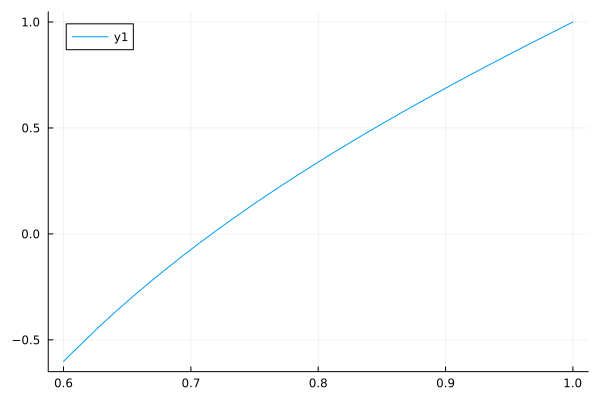

In [10]:
a, b, p = 3, 2, 0.6
plot(t -> chareq(a, b, p, t), 0.6, 1)

In [11]:
#??find_zero

a = 0.4
b = 0.5
p = 0.55
M = 5
N = 5
prob_ge_M(a, b, p, M, N) = 0.43787213592106555
  0.581831 seconds (596.40 k allocations: 318.726 MiB, 28.93% gc time, 29.71% compilation time)
alpha1 = mean(lastX .≥ M) = 0.43572
alpha0 = mean(lastX .≤ -N) = 0.56428
alpha1 + alpha0 = 1.0


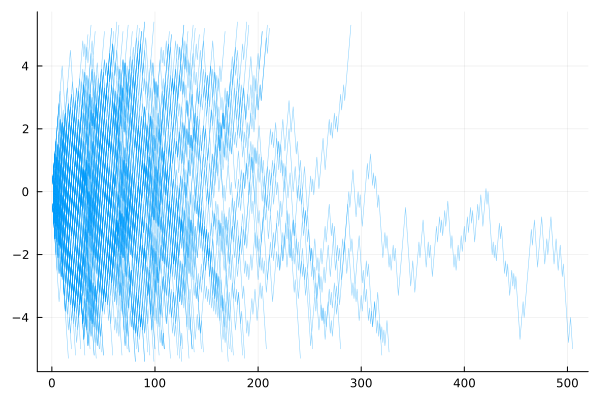

In [12]:
a, b, p, M, N = 0.4, 0.5, 0.55, 5, 5
@show a b p M N
@show prob_ge_M(a, b, p, M, N)
@time X, lastX = sim_random_walks(a, b, p, M, N; nmax=10^4, niters=10^5)
@show alpha1 = mean(lastX .≥ M)
@show alpha0 = mean(lastX .≤ -N)
@show alpha1 + alpha0

plot()
for i in 1:100
    plot!(X[i]; label="", c=1, lw=0.5, alpha=0.5)
end
plot!()

p0 = 0.3
p1 = 0.5
p = 0.3
C0 = 0.1
C1 = 10
logC0 = -2.3025850929940455
logC1 = 2.302585092994046
prob_accept(p0, p1, p, C0, C1) = 0.9090909090909087
  0.140118 seconds (178.19 k allocations: 14.390 MiB, 12.10% gc time, 57.85% compilation time)
mean(lenLLR) = 25.0338
std(lenLLR) = 18.036329684246954
alpha1 = mean(lastLLR .≥ logC1) = 0.9298
alpha0 = mean(lastLLR .≤ logC0) = 0.0702
alpha1 + alpha0 = 1.0


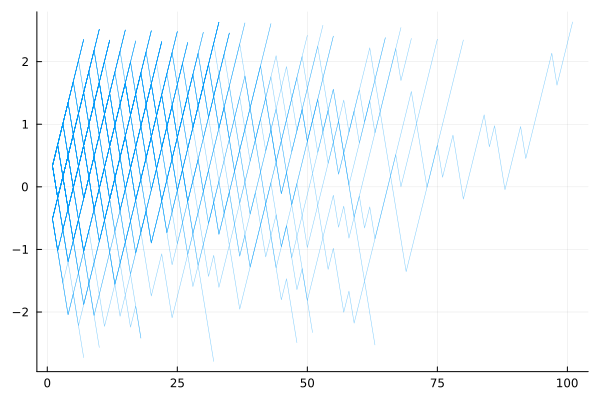

In [13]:
p0, p1, p, C0, C1 = 0.3, 0.5, 0.3, 1/10, 10
logC0, logC1 = log(C0), log(C1)
@show p0 p1 p C0 C1 logC0 logC1
@show prob_accept(p0, p1, p, C0, C1)
@time LLR, lastLLR, lenLLR = sim_likrat_tests(p0, p1, p, C0, C1; nmax=10^3, niters=10^4)
@show mean(lenLLR) std(lenLLR)
@show alpha1 = mean(lastLLR .≥ logC1)
@show alpha0 = mean(lastLLR .≤ logC0)
@show alpha1 + alpha0

plot()
for i in 1:100
    plot!(LLR[i]; label="", c=1, lw=0.5, alpha=0.5)
end
plot!()

p0 = 0.3
p1 = 0.4
p = 0.3
C0 = 0.0625
C1 = 16
logC0 = -2.772588722239781
logC1 = 2.772588722239781
prob_accept(p0, p1, p, C0, C1) = 0.9411764705882345
  0.202288 seconds (42.61 k allocations: 27.790 MiB)
mean(lenLLR) = 117.8417
std(lenLLR) = 83.33464530086357
alpha1 = mean(lastLLR .≥ logC1) = 0.9479
alpha0 = mean(lastLLR .≤ logC0) = 0.0521
alpha1 + alpha0 = 1.0


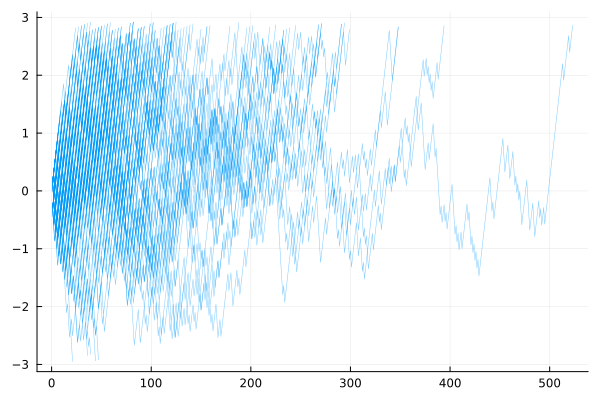

In [14]:
p0, p1, p, C0, C1 = 0.3, 0.4, 0.3, 1/16, 16
logC0, logC1 = log(C0), log(C1)
@show p0 p1 p C0 C1 logC0 logC1
@show prob_accept(p0, p1, p, C0, C1)
@time LLR, lastLLR, lenLLR = sim_likrat_tests(p0, p1, p, C0, C1; nmax=10^3, niters=10^4)
@show mean(lenLLR) std(lenLLR)
@show alpha1 = mean(lastLLR .≥ logC1)
@show alpha0 = mean(lastLLR .≤ logC0)
@show alpha1 + alpha0

plot()
for i in 1:100
    plot!(LLR[i]; label="", c=1, lw=0.5, alpha=0.5)
end
plot!()

(p0, p1, p_true, C0, C1) = (0.3, 0.5, 0.3, 0.1, 10)
(logC0, logC1) = (-2.3025850929940455, 2.302585092994046)
prob_accept(p0, p1, p_true, C0, C1) = 0.9090909090909087
  0.041841 seconds (30.61 k allocations: 6.823 MiB)
mean(lenLLR) = 25.2335
std(lenLLR) = 18.245911023484354
alpha1 = mean(lastLLR .≥ logC1) = 0.9238
alpha0 = mean(lastLLR .≤ logC0) = 0.0762
alpha1 + alpha0 = 1.0


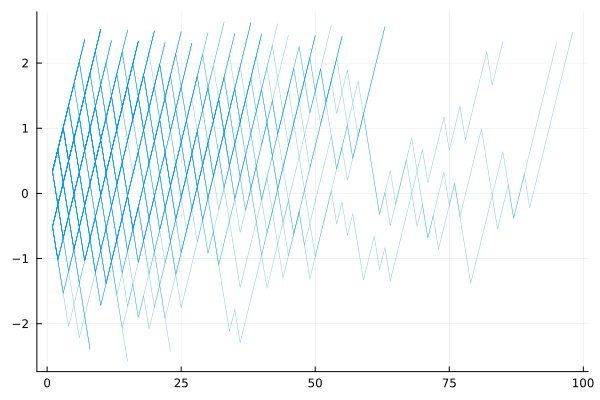

In [15]:
p0, p1, p_true, C0, C1 = 0.3, 0.5, 0.3, 1/10, 10
logC0, logC1 = log(C0), log(C1)
@show p0, p1, p_true, C0, C1
@show logC0, logC1
@show prob_accept(p0, p1, p_true, C0, C1)
@time LLR, lastLLR, lenLLR = sim_likrat_tests(p0, p1, p, C0, C1; nmax=10^3, niters=10^4)
@show mean(lenLLR) std(lenLLR)
@show alpha1 = mean(lastLLR .≥ logC1)
@show alpha0 = mean(lastLLR .≤ logC0)
@show alpha1 + alpha0

plot()
for i in 1:100
    plot!(LLR[i]; label="", c=1, lw=0.5, alpha=0.5)
end
plot!()

(p0, p1, p_true, C0, C1) = (0.3, 0.4, 0.3, 0.05, 10)
(logC0, logC1) = (-2.995732273553991, 2.302585092994046)
prob_accept(p0, p1, p_true, C0, C1) = 0.9547738693467329
  0.174936 seconds (40.51 k allocations: 23.291 MiB)
mean(lenLLR) = 98.7738
std(lenLLR) = 75.22026749769135
alpha1 = mean(lastLLR .≥ logC1) = 0.9587
alpha0 = mean(lastLLR .≤ logC0) = 0.0413
alpha1 + alpha0 = 1.0


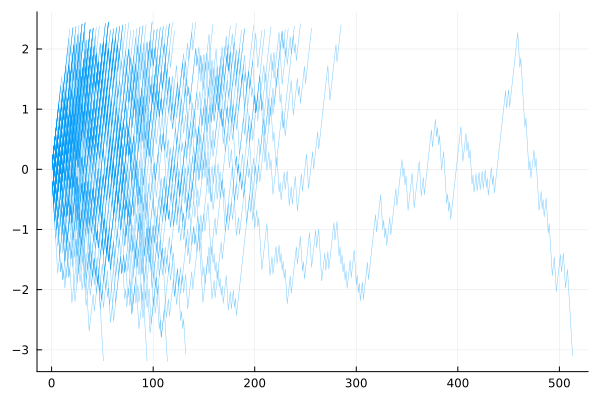

In [16]:
p0, p1, p_true, C0, C1 = 0.3, 0.4, 0.3, 1/20, 10
logC0, logC1 = log(C0), log(C1)
@show p0, p1, p_true, C0, C1
@show logC0, logC1
@show prob_accept(p0, p1, p_true, C0, C1)
@time LLR, lastLLR, lenLLR = sim_likrat_tests(p0, p1, p, C0, C1; nmax=10^3, niters=10^4)
@show mean(lenLLR) std(lenLLR)
@show alpha1 = mean(lastLLR .≥ logC1)
@show alpha0 = mean(lastLLR .≤ logC0)
@show alpha1 + alpha0

plot()
for i in 1:100
    plot!(LLR[i]; label="", c=1, lw=0.5, alpha=0.5)
end
plot!()

(p0, p1, p_true, C0, C1) = (0.5, 0.3, 0.3, 0.1, 16)
(logC0, logC1) = (-2.3025850929940455, 2.772588722239781)
prob_accept(p0, p1, p_true, C0, C1) = 0.05660377358490581
  0.045649 seconds (30.91 k allocations: 7.116 MiB)
mean(lenLLR) = 26.5159
std(lenLLR) = 19.583791759512966
alpha1 = mean(lastLLR .≥ logC1) = 0.0477
alpha0 = mean(lastLLR .≤ logC0) = 0.9523
alpha1 + alpha0 = 1.0


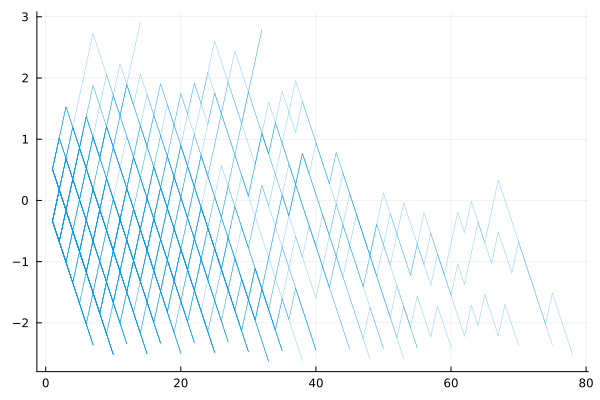

In [17]:
p0, p1, p_true, C0, C1 = 0.5, 0.3, 0.3, 1/10, 16
logC0, logC1 = log(C0), log(C1)
@show p0, p1, p_true, C0, C1
@show logC0, logC1
@show prob_accept(p0, p1, p_true, C0, C1)
@time LLR, lastLLR, lenLLR = sim_likrat_tests(p0, p1, p, C0, C1; nmax=10^3, niters=10^4)
@show mean(lenLLR) std(lenLLR)
@show alpha1 = mean(lastLLR .≥ logC1)
@show alpha0 = mean(lastLLR .≤ logC0)
@show alpha1 + alpha0

plot()
for i in 1:100
    plot!(LLR[i]; label="", c=1, lw=0.5, alpha=0.5)
end
plot!()

In [18]:
p0, p1, p_true = 0.3, 0.6, 0.6
p = p0 < p1 ? 1-p_true : p_true
a = p0 < p1 ? log(1-p0)-log(1-p1) : log(p0)-log(p1)
b = p0 < p1 ? log(p1)-log(p0) : log(1-p1)-log(1-p0)
@show exp(a), exp(-b), p
λ = sol_chareq(a, b, p)
@show λ, 1/λ

@show p*λ^a + (1-p)*λ^(-b)
;

(exp(a), exp(-b), p) = (1.7499999999999998, 0.49999999999999994, 0.4)
(λ, 1 / λ) = (2.718281828459047, 0.3678794411714421)
p * λ ^ a + (1 - p) * λ ^ -b = 1.0


In [19]:
p0, p1, p_true = 0.7, 0.3, 0.3
p = p0 < p1 ? 1-p_true : p_true
a = p0 < p1 ? log(1-p0)-log(1-p1) : log(p0)-log(p1)
b = p0 < p1 ? log(p1)-log(p0) : log(1-p1)-log(1-p0)
λ = sol_chareq(a, b, p)
@show λ, 1/λ
;

(λ, 1 / λ) = (2.7182818284590446, 0.3678794411714424)


(α, β) = (0.05, 0.2) = (0.05, 0.2)
(M, N) = (log((1 - α) / (1 - β)), log(β / α)) = (0.17185025692665903, 1.3862943611198906)
((exp(-N) - 1) / (exp(-M - N) - 1), (exp(N) - 1) / (exp(M + N) - 1)) = (0.95, 0.8000000000000002)
(p0, p1, p_true, C0, C1) = (0.3, 0.35, 0.3, 0.25, 1.1874999999999998)
(logC0, logC1) = (-1.3862943611198906, 0.17185025692665903)
prob_accept(p0, p1, p_true, C0, C1) = 0.9499999999999995
  0.033252 seconds (26.80 k allocations: 5.854 MiB)
mean(lenLLR) = 21.5232
std(lenLLR) = 33.33493038118352
alpha1 = mean(lastLLR .≥ logC1) = 0.9429
alpha0 = mean(lastLLR .≤ logC0) = 0.0571
alpha1 + alpha0 = 1.0


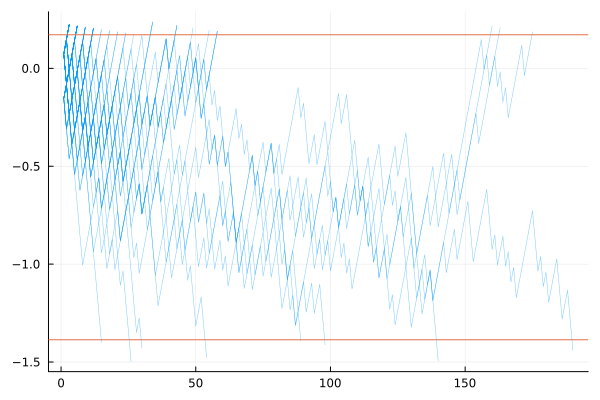

In [39]:
@show α, β = 0.05, 0.20
@show M, N = log((1-α)/(1-β)), log(β/α)
@show (exp(-N)-1)/(exp(-M-N)-1), (exp(N)-1)/(exp(M+N)-1)

p0, p1, p_true, C0, C1 = 0.3, 0.35, 0.3, α/β, (1-α)/(1-β)
logC0, logC1 = log(C0), log(C1)
@show p0, p1, p_true, C0, C1
@show logC0, logC1
@show prob_accept(p0, p1, p_true, C0, C1)
@time LLR, lastLLR, lenLLR = sim_likrat_tests(p0, p1, p_true, C0, C1; nmax=10^4, niters=10^4)
@show mean(lenLLR) std(lenLLR)
@show alpha1 = mean(lastLLR .≥ logC1)
@show alpha0 = mean(lastLLR .≤ logC0)
@show alpha1 + alpha0

plot()
for i in 1:100
    plot!(LLR[i]; label="", c=1, lw=0.5, alpha=0.5)
end
hline!([logC0, logC1]; c=2, label="")
plot!()

(α, β) = (0.05, 0.2) = (0.05, 0.2)
(M, N) = (log((1 - α) / (1 - β)), log(β / α)) = (0.17185025692665903, 1.3862943611198906)
((exp(-N) - 1) / (exp(-M - N) - 1), (exp(N) - 1) / (exp(M + N) - 1)) = (0.95, 0.8000000000000002)
(p0, p1, p_true, C0, C1) = (0.3, 0.35, 0.35, 0.25, 1.1874999999999998)
(logC0, logC1) = (-1.3862943611198906, 0.17185025692665903)
prob_accept(p0, p1, p_true, C0, C1) = 0.7999999999999993
  0.049372 seconds (29.01 k allocations: 8.121 MiB)
mean(lenLLR) = 31.0589
std(lenLLR) = 40.97786901932478
alpha1 = mean(lastLLR .≥ logC1) = 0.7643
alpha0 = mean(lastLLR .≤ logC0) = 0.2357
alpha1 + alpha0 = 1.0


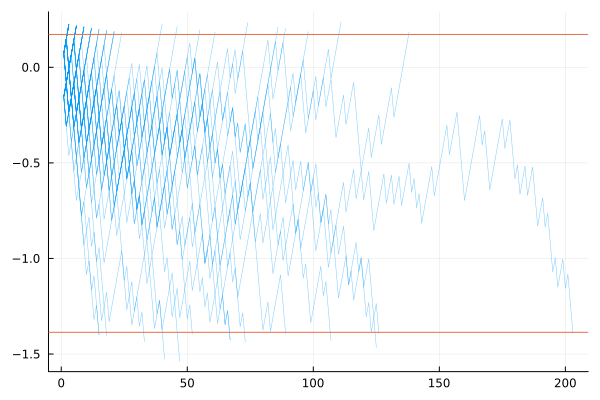

In [38]:
@show α, β = 0.05, 0.20
@show M, N = log((1-α)/(1-β)), log(β/α)
@show (exp(-N)-1)/(exp(-M-N)-1), (exp(N)-1)/(exp(M+N)-1)

p0, p1, p_true, C0, C1 = 0.3, 0.35, 0.35, α/β, (1-α)/(1-β)
logC0, logC1 = log(C0), log(C1)
@show p0, p1, p_true, C0, C1
@show logC0, logC1
@show prob_accept(p0, p1, p_true, C0, C1)
@time LLR, lastLLR, lenLLR = sim_likrat_tests(p0, p1, p_true, C0, C1; nmax=10^4, niters=10^4)
@show mean(lenLLR) std(lenLLR)
@show alpha1 = mean(lastLLR .≥ logC1)
@show alpha0 = mean(lastLLR .≤ logC0)
@show alpha1 + alpha0

plot()
for i in 1:100
    plot!(LLR[i]; label="", c=1, lw=0.5, alpha=0.5)
end
hline!([logC0, logC1]; c=2, label="")
plot!()

(α, β) = (0.025, 0.2) = (0.025, 0.2)
(M, N) = (log((1 - α) / (1 - β)), log(β / α)) = (0.19782574332991987, 2.0794415416798357)
((exp(-N) - 1) / (exp(-M - N) - 1), (exp(N) - 1) / (exp(M + N) - 1)) = (0.9750000000000001, 0.8000000000000002)

(p0, p1, p_true, C0, C1) = (0.3, 0.35, 0.3, 0.125, 1.21875)
(logC0, logC1) = (-2.0794415416798357, 0.19782574332991987)
_abpMN(p0, p1, p_true, M, N) = (0.07410797215372178, 0.15415067982725827, 0.7, 0.7320993680864453, 1.6203687199813912)
prob_accept(p0, p1, p_true, C0, C1) = 0.9749999999999996

  0.049534 seconds (27.50 k allocations: 7.503 MiB)
mean(lenLLR) = 28.8646
std(lenLLR) = 54.65118060933541
alpha1 = mean(lastLLR .≥ logC1) = 0.9746
alpha0 = mean(lastLLR .≤ logC0) = 0.0254
alpha1 + alpha0 = 1.0


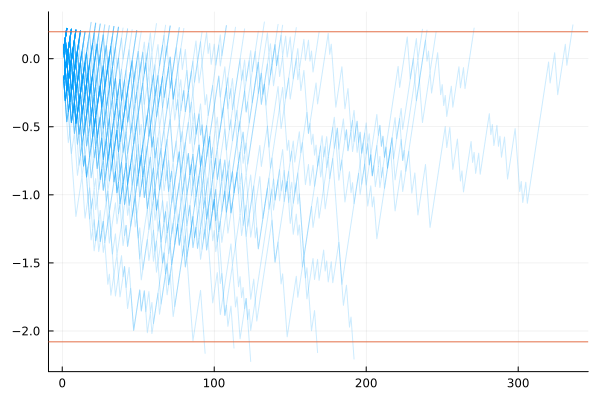

In [54]:
@show α, β = 0.025, 0.20
@show M, N = log((1-α)/(1-β)), log(β/α)
@show (exp(-N)-1)/(exp(-M-N)-1), (exp(N)-1)/(exp(M+N)-1)

println()

p0, p1, p_true, C0, C1 = 0.30, 0.35, 0.30, α/β, (1-α)/(1-β)
logC0, logC1 = log(C0), log(C1)
@show p0, p1, p_true, C0, C1
@show logC0, logC1
@show _abpMN(p0, p1, p_true, M, N)
@show prob_accept(p0, p1, p_true, C0, C1)

println()

@time LLR, lastLLR, lenLLR = sim_likrat_tests(p0, p1, p_true, C0, C1; nmax=10^4, niters=10^4)
@show mean(lenLLR) std(lenLLR)
@show alpha1 = mean(lastLLR .≥ logC1)
@show alpha0 = mean(lastLLR .≤ logC0)
@show alpha1 + alpha0

plot()
for i in 1:200
    plot!(LLR[i]; label="", c=1, lw=1, alpha=0.2)
end
hline!([logC0, logC1]; c=2, label="")
plot!()